# Example ERA5 

### Time period

We will use data from 1985 to 2014.

### Variables 

| shortname     |             Long name                   |      Units    |  levels |
| ------------- |:---------------------------------------:| -------------:|--------:|
| sf            |    snowfall                             |[m of water eq]| surface |
| msr           |    mean_snowfall_rate                   |[kg m-2 s-1]   | surface |
| cswc          |    specific_snow_water_content          | [kg kg-1]     |    pl   |
| clwc          |    specific_cloud_liquid_water_content  |   [kg kg-1]   |    pl   |
| clic          |    specific_cloud_ice_water_content     | [kg kg-1]     |    pl   |
| t             |    temperature                          |  [K]          |    pl   |
| 2t            |    2 metre temperature                  |  [K]          | surface |
| tclw          |   Total column cloud liquid water       |  [kg m-2]     | single  |
| tciw          |   Total column cloud ice water          |  [kg m-2]     | single  |






## Import python packages

In [1]:

# supress warnings
import warnings
warnings.filterwarnings('ignore') # don't output warnings

# import packages
import sys
sys.path.append('/uio/kant/geo-metos-u1/franzihe/Documents/Python/globalsnow/eosc-nordic-climate-demonstrator/work/')
import xarray as xr
xr.set_options(display_style='html')
import intake
import cartopy.crs as ccrs
import cartopy as cy
import matplotlib.pyplot as plt
from glob import glob
from cmcrameri import cm

import functions as fct



In [2]:
# reload imports
%load_ext autoreload
%autoreload 2

Open ERA5 variables

In [3]:
input_data = '/scratch/franzihe/input'
output_data = '/scratch/franzihe/output'

In [4]:
era_in = '{}/ERA5/monthly_means/0.25deg'.format(input_data)
era_out = '{}/ERA5/monthly_means/1deg'.format(output_data)

variable_id=[
            # 'sf', 
            'tciw',
            # 'tclw',
            # '2t'
             ]

# Regrid ERA5 data to common NorESM2-MM grid

In [5]:

starty = 1985; endy = 2014
year_range = range(starty, endy+1)

# Read in regridder data (NorESM)
cmip_file = '/scratch/franzihe/input/cmip6_hist/1deg/grid_NorESM2-MM.nc'
ds_out = xr.open_dataset(cmip_file)

counter = 0
for var_id in variable_id:
    # select where data should be saved
    filename = '{}_Amon_1deg_{}01_{}12.nc'.format(var_id, starty, endy)
    era_file_out = era_out + '/' + filename
    files = glob(era_file_out)
            
    if era_file_out in files:
        print('{} is downloaded'.format(era_file_out))
        counter += 1
        print('Have regridded in total: {:} files'.format(str(counter)))
    else:
        # Input data from ERA5 with a resolution of 0.25x0.25deg to be regridded
        era_file_in = glob('{}/{}_Amon_ERA5_*12.nc'.format(era_in, var_id,))        
        ds_in = xr.open_mfdataset(era_file_in)
        ds_in = ds_in.sel(time = ds_in.time.dt.year.isin(year_range)).squeeze()
            
        # Regrid data
        ds_in_regrid = fct.regrid_data(ds_in, ds_out)
                
        # Shift the longitude from 0-->360 to -180-->180 and sort by longitude and time
        ds_in_regrid = ds_in_regrid.assign_coords(lon=(((ds_in_regrid.lon + 180) % 360) - 180)).sortby('lon').sortby('time')
                
                
        # Save to netcdf file
        ds_in_regrid.to_netcdf(era_file_out)
        ds_in.close(); ds_out.close()
        print('file written: {}'.format(era_file_out))
        
    

tciw True
file written: /scratch/franzihe/output/ERA5/monthly_means/1deg/tciw_Amon_1deg_198501_201412.nc


# Create seasonal mean of all regridded ERA5

In [6]:
# seasonal mean of all models 
sf = ds_in_regrid.groupby('time.season').mean('time', keep_attrs = True)

# select where data should be saved
filename = '{}_season_1deg_{}_{}.nc'.format(variable_id[0], starty, endy)
nc_out = era_out + '/' + filename
files = glob(nc_out)


counter = 0 
# Save to netcdf file
if nc_out in files:
    print('{} is downloaded'.format(nc_out))
    counter += 1
    print('Have saved in total: {:} files'.format(str(counter)))
else:
    sf.to_netcdf(nc_out)
    print('file written: .{}'.format(nc_out))




file written: ./scratch/franzihe/output/ERA5/monthly_means/1deg/tciw_season_1deg_1985_2014.nc


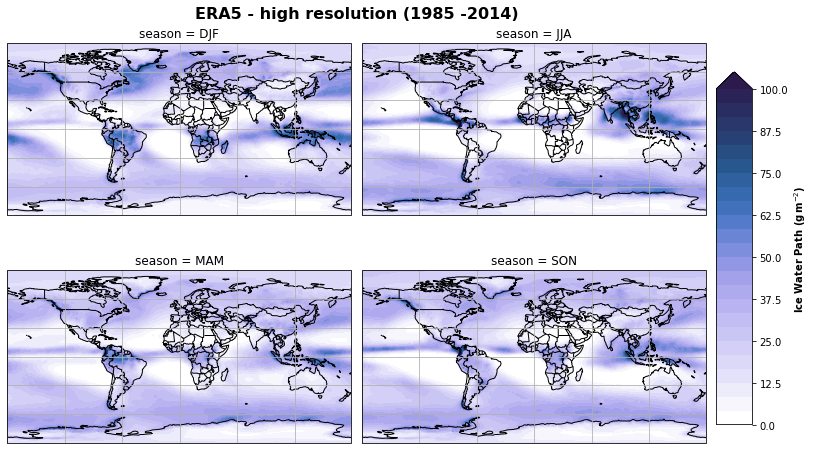

In [7]:
fig, axsm = plt.subplots(2,2, 
                         figsize=[10,7], 
                         subplot_kw={'projection':ccrs.PlateCarree()})
fig.suptitle('ERA5 - high resolution (1985 -2014)', fontsize=16, fontweight="bold")

axs = axsm.flatten()
for ax, i in zip(axs, sf.season):
    if variable_id[0] == 'sf':
        im = (sf[variable_id[0]].sel(season = i)*1000).plot.contourf(ax=ax, 
                                     transform=ccrs.PlateCarree(), 
                                     robust=True,
                                     cmap=cm.devon_r,
                                     vmin = 0, vmax = 2.5,
                                     levels = 25,
                                     add_colorbar = False,
                                     extend = 'max')


    elif variable_id[0] == 'tclw' or variable_id[0] == 'tciw':
        im = (sf[variable_id[0]].sel(season = i)*1000).plot.contourf(ax=ax, 
                                     transform=ccrs.PlateCarree(), 
                                     cmap=cm.devon_r,
                                     robust=True,
                                     vmin = 0, vmax=100, 
                                     levels = 25,
                                     add_colorbar = False,
                                     extend = 'max')

    elif variable_id[0] == '2t':
        im = sf['t2m'].sel(season = i).plot.contourf(ax=ax, 
                                     transform=ccrs.PlateCarree(), 
                                     cmap=cm.vik,
                                     robust=True,
                                     vmin = 246 , vmax=300, 
                                     levels = 40,
                                     add_colorbar = False,
                                     extend = 'both')
    
        

    ax.coastlines()
    gl = ax.gridlines()
    ax.add_feature(cy.feature.BORDERS);
    gl.top_labels = False

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([1, 0.15, 0.05, 0.7])
cb = fig.colorbar(im, cax=cbar_ax, orientation="vertical", fraction=0.046, pad=0.04)


if variable_id[0] == 'sf':
    cb.set_label(label='Snowfall (mm$\,$day$^{-1}$)', weight='bold')
elif variable_id[0] == 'tciw':
    cb.set_label(label='Ice Water Path (g$\,$m$^{-2}$)', weight='bold')
elif variable_id[0] == 'tclw':
    cb.set_label(label='Liquid Water Path (g$\,$m$^{-2}$)', weight='bold')
elif variable_id[0] == '2t':
    cb.set_label(label='2-m temperature (K)', weight='bold')



plt.tight_layout()
fig.subplots_adjust(top=1)

# save figure to png
figdir = '/uio/kant/geo-metos-u1/franzihe/Documents/Figures/ERA5/'
figname = '{}_season_1deg_{}_{}.png'.format(variable_id[0], starty, endy)
plt.savefig(figdir + figname, format = 'png', bbox_inches = 'tight', transparent = False)